# Correlations and Data Dispersion

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
import cleaning_funs #Python file attached
from matplotlib import rcParams
from bidi.algorithm import get_display  
import arabic_reshaper  

import warnings
warnings.filterwarnings("ignore")

In [12]:
df_original= pd.read_csv('dataset.csv')

In [13]:
df_original.describe()

,Year,Hand,Price,Pic_num,Supply_score
count,1500.000000,1500.000000,1500.000000,1476.000000,439.000000
mean,2014.346000,2.349333,51085.086000,2.836721,1581.011390
std,3.815406,1.229217,21933.308735,3.499312,2651.323149
min,1983.000000,1.000000,18200.000000,0.000000,0.000000
25%,2012.000000,1.000000,32000.000000,1.000000,20.000000
50%,2015.000000,2.000000,48000.000000,1.000000,474.000000
75%,2017.000000,3.000000,68000.000000,4.000000,2402.000000
max,2023.000000,10.000000,99960.000000,40.000000,16508.000000


## prepare_data

In [14]:
def cleaning_add_columns(df):
    # Ensure 'Description' column is of type string
    df['Description'] = df['Description'].astype('string')
    
    # Apply text cleaning functions
    df['Description'] = df['Description'].apply(cleaning_funs.clean_text_robust)
    df['model'] = df['model'].apply(cleaning_funs.clean_text_robust)
    
    # Clean 'capacity_Engine' column
    df['capacity_Engine'] = df['capacity_Engine'].replace(',', '', regex=True)
    
    # Apply custom functions to handle least frequent categories and conversions
    df = cleaning_funs.Color_least_frequent(df, 'Color', 'Processed_Colors')
    df = cleaning_funs.Engine_type_least_frequent(df, 'Engine_type')
    df = cleaning_funs.ownership_least_frequent(df, 'Curr_ownership', 'Processed_Curr_ownership')
    df = cleaning_funs.ownership_least_frequent(df, 'Prev_ownership', 'Processed_Prev_ownership')
    
    df = cleaning_funs.convert_to_date_and_calculate_days_and_check(df, 'Cre_date')
    df = cleaning_funs.convert_to_date_and_calculate_days_and_check(df, 'Repub_date')
    df = cleaning_funs.convert_Km(df, 'Km', 'Processed_Km')
    df = cleaning_funs.process_gear_column(df)
    df = cleaning_funs.process_manufactor_column(df)
    df = cleaning_funs.Processed_Test(df)
    df = cleaning_funs.process_accident_column(df, 'Description')
    df = cleaning_funs.convert_cap(df, 'capacity_Engine', 'Processed_capacity_Engine')
    df = cleaning_funs.update_description_length(df, 'Description', 'description_length')
    
    # Combine ownership columns
    df['Total_Ownership'] = df['Processed_Prev_ownership'].fillna('') + '_' + df['Processed_Curr_ownership']
    
    # Extract and process additional features
    df['dats_Test'] = df['Description'].apply(cleaning_funs.extract_test_dates_extended)
    df['Processed_Test'] = df.apply(cleaning_funs.apply_days_until_end_of_month, axis=1)
    df['Processed_model'] = df['model'].apply(cleaning_funs.translate_model)
    
    # Convert columns to appropriate types
    df['Total_Ownership'] = df['Total_Ownership'].astype('category')
    df['Processed_model'] = df['Processed_model'].astype('category')
    df['Processed_manufactor'] = df['Processed_manufactor'].astype('category')
    df['Processed_Gear'] = df['Processed_Gear'].astype('category')
    df['Processed_Colors'] = df['Processed_Colors'].astype('category')
    df['Processed_Engine_type'] = df['Processed_Engine_type'].astype('category')
    df['Processed_Curr_ownership'] = df['Processed_Curr_ownership'].astype('category')
    df['Processed_Prev_ownership'] = df['Processed_Prev_ownership'].astype('category')
    df['Processed_Test'] = pd.to_numeric(df['Processed_Test'], errors='coerce').astype('Int64')
    df = cleaning_funs.map_areas(df)
    df['Processed_Area'] = df['Processed_Area'].astype('category')
    df = cleaning_funs.fill_supply_score(df) #Processed_Supply_score
    # Create new features
    df['Car_Age'] = datetime.datetime.now().year - df['Year']
    df['Km_Per_Year'] = df['Processed_Km'] / df['Car_Age']
    df['Km_Per_Year'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df['Km_Per_Year'].fillna(df['Processed_Km'], inplace=True)
    df = cleaning_funs.convert_to_date_for_age(df, 'Repub_date')
    
    # Define the columns to copy
    columns_to_copy = [
        'Price', 'Car_Age', 'Age_Car_Repub_date', 'Hand', 'Pic_num', 'Processed_Supply_score', 'description_length', 
        'Processed_Colors','Processed_Engine_type', 'Processed_Area', 'Processed_Repub_date', 'Processed_capacity_Engine', 
        'Processed_Km', 'Processed_Gear','Processed_manufactor', 'Processed_Test', 'Processed_accident','Processed_model',
        'Total_Ownership', 'Km_Per_Year']
    
    # Select the relevant columns
    df_p = df[columns_to_copy]
   # df = df.drop_duplicates()
    return df_p
    
df_p = cleaning_add_columns(df_original)

In [22]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1499 entries, 0 to 1499
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Price                      1499 non-null   float64 
 1   Car_Age                    1499 non-null   int64   
 2   Age_Car_Repub_date         1458 non-null   float64 
 3   Hand                       1499 non-null   int64   
 4   Pic_num                    1475 non-null   float64 
 5   Processed_Supply_score     520 non-null    float64 
 6   description_length         1499 non-null   int64   
 7   Processed_Colors           786 non-null    category
 8   Processed_Engine_type      1494 non-null   category
 9   Processed_Area             1499 non-null   category
 10  Processed_Repub_date       1456 non-null   float64 
 11  Processed_capacity_Engine  1462 non-null   Int64   
 12  Processed_Km               1406 non-null   Int64   
 13  Processed_Gear             1497 n

Skewness: 0.360315
Kurtosis: -0.985145


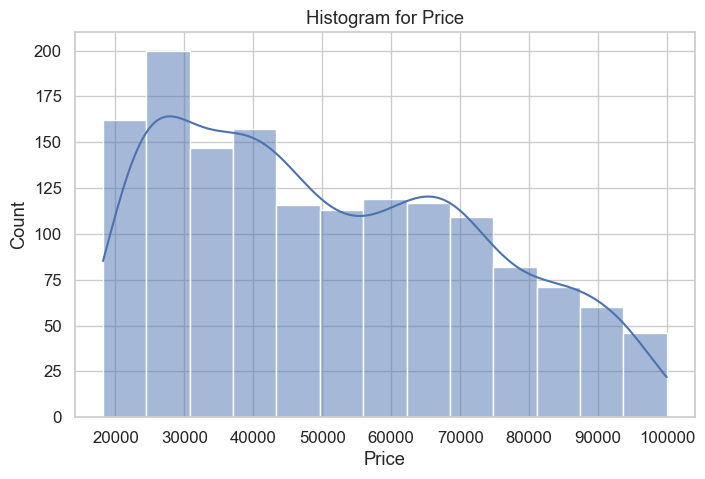

In [17]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.histplot(df_p['Price'],kde=True)
plt.title("Histogram for Price")
# Skew and kurt
print("Skewness: %f" % df_p['Price'].skew())
print("Kurtosis: %f" % df_p['Price'].kurt())

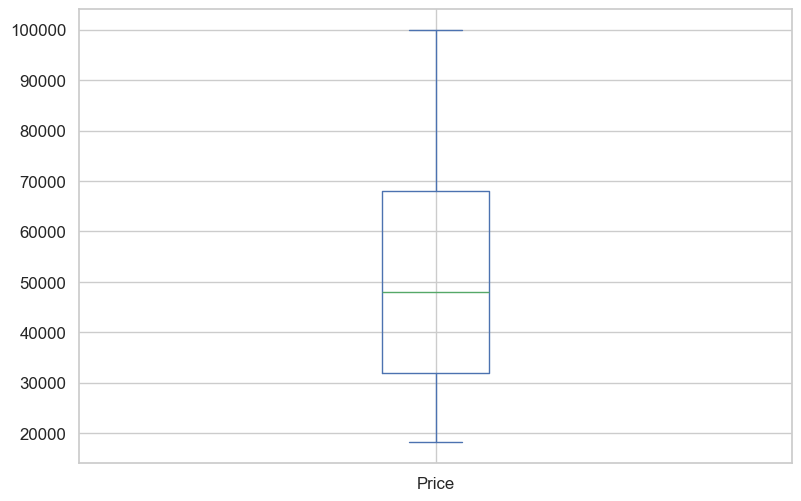

In [18]:
df_p.Price.plot.box()
plt.tight_layout(pad=0.5)

((array([-3.31251884, -3.05584353, -2.91313651, ...,  2.91313651,
          3.05584353,  3.31251884]),
  array([18200., 18400., 18500., ..., 99000., 99000., 99960.])),
 (21398.489178966924, 51059.12541694464, 0.9747415006585759))

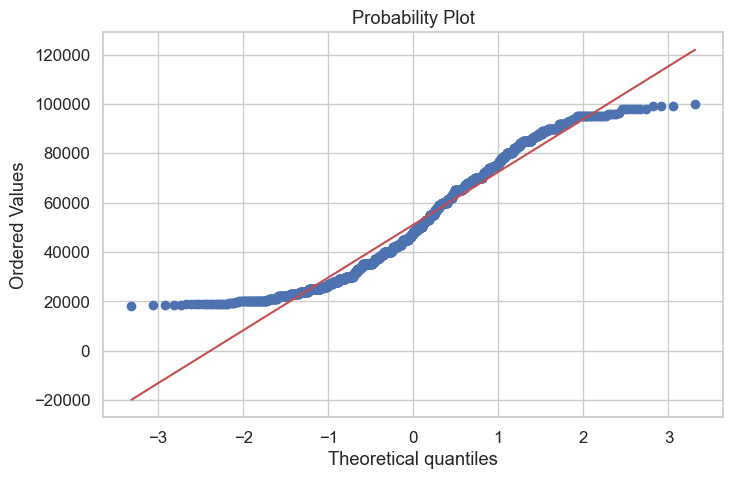

In [19]:
from scipy import stats
stats.probplot(df_p.Price, plot=sns.mpl.pyplot)

data.Speed.plot(kind = 'hist',bins = 50,figsize = (12,12))
plt.show() אחרי המרה של הנתונים נבדוק גם התפלגויות\פיזור של הנתונים 

<Axes: >

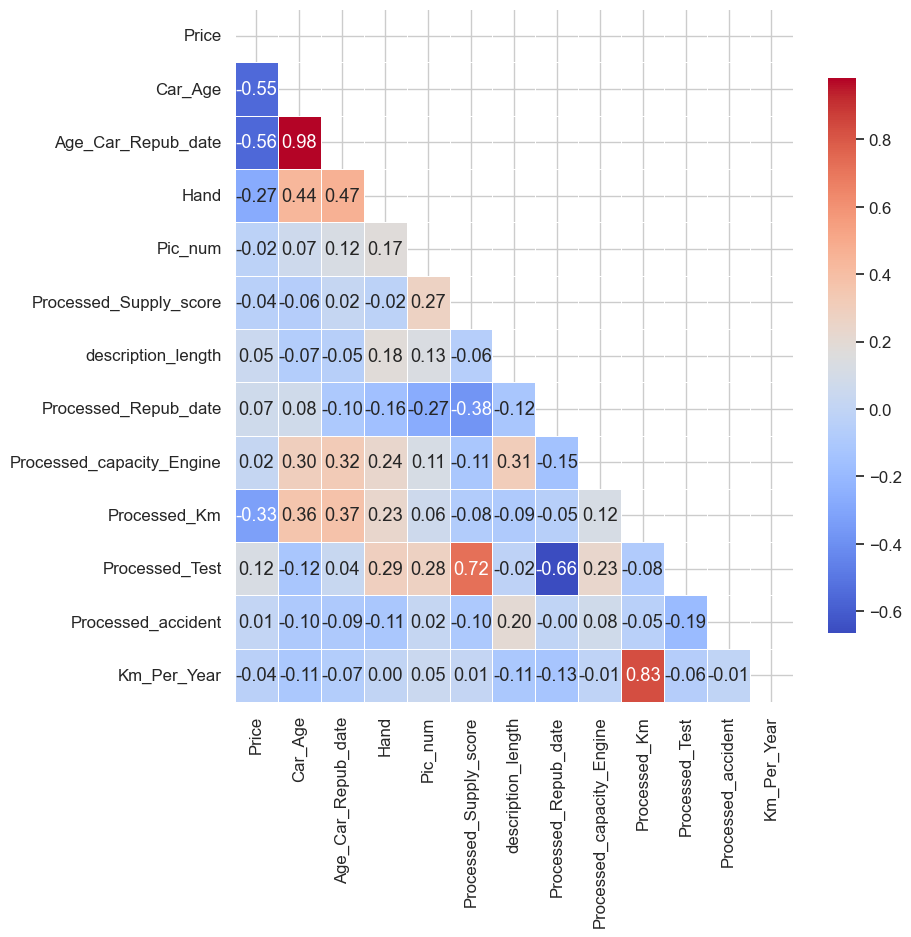

In [21]:
corr = df_p.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(9,9))

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": .8})

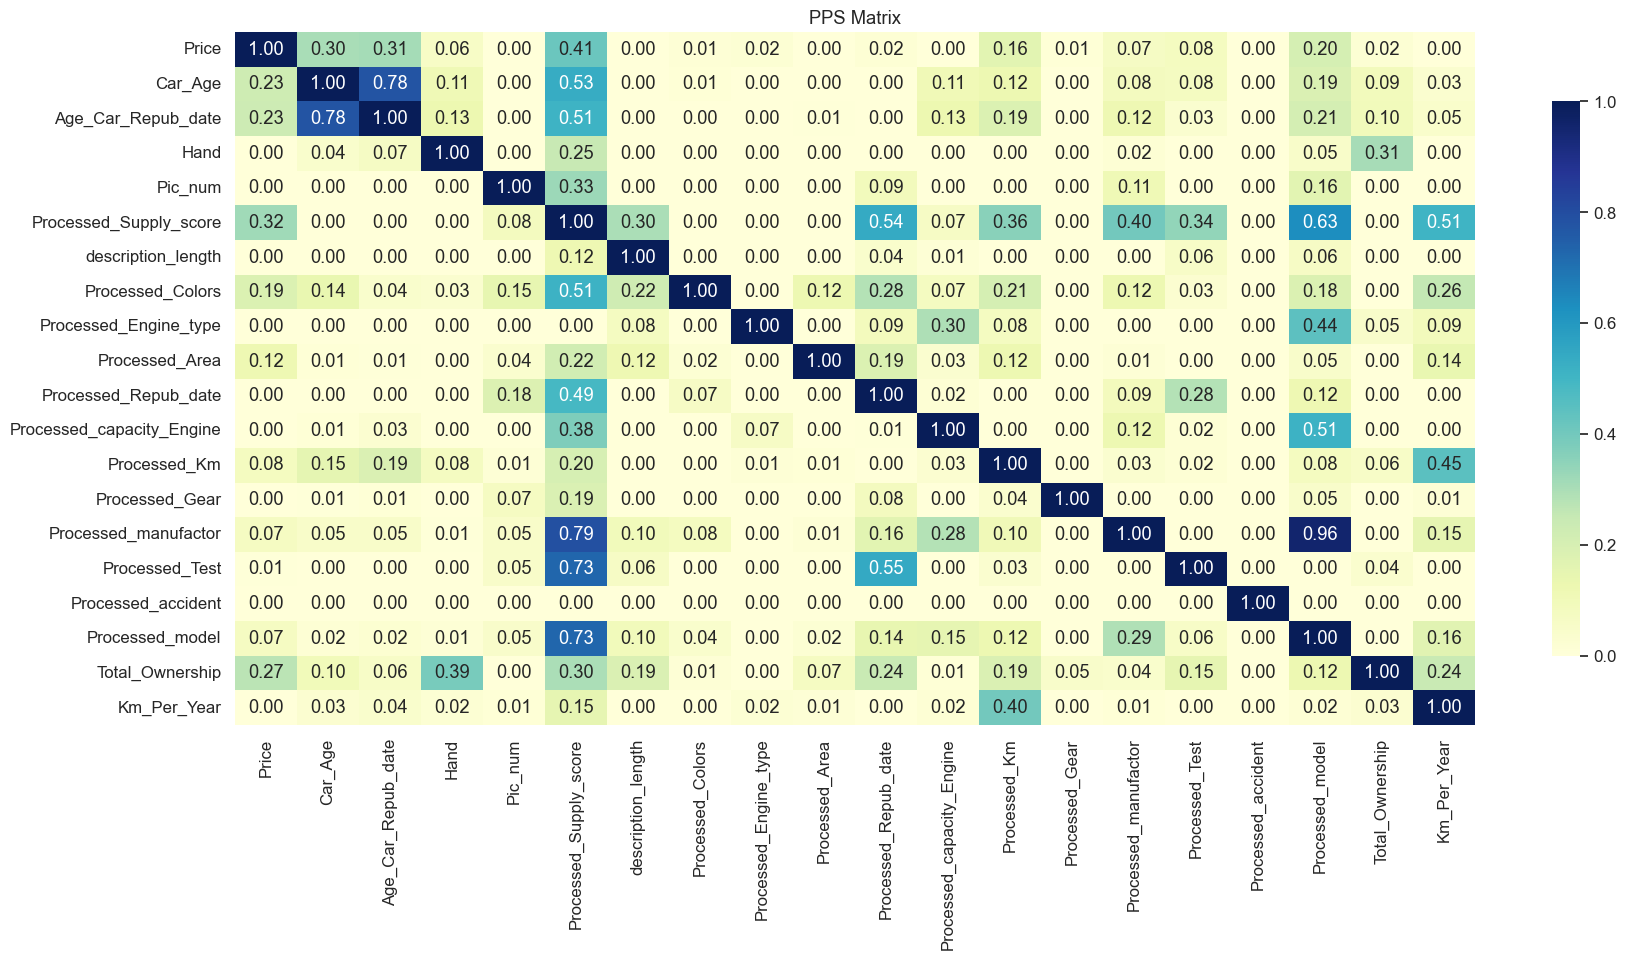

In [23]:
pps_matrix = pps.matrix(df_p)
pps_matrix_pivot = pps_matrix.pivot(columns='x', index='y', values='ppscore')
pps_matrix_pivot = pps_matrix_pivot.loc[df_p.columns, df_p.columns]

plt.figure(figsize=(20, 9))
sns.heatmap(pps_matrix_pivot, annot=True, cmap="YlGnBu", cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('PPS Matrix')
plt.show()

In [24]:
rcParams['axes.unicode_minus'] = False
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'

In [39]:
df_p_v = df_p.copy()
df_p_v['Processed_manufactor_visual'] = df_p_v['Processed_manufactor'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))
df_p_v['Processed_Colors_visual'] = df_p_v['Processed_Colors'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))
df_p_v['Processed_Engine_type_visual'] = df_p_v['Processed_Engine_type'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))
df_p_v['Processed_Area_visual'] = df_p_v['Processed_Area'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))
df_p_v['Processed_manufactor_visual'] = df_p_v['Processed_manufactor'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))
df_p_v['Processed_Gear_visual'] = df_p_v['Processed_Gear'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))
df_p_v['Total_Ownership_visual'] = df_p_v['Total_Ownership'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))

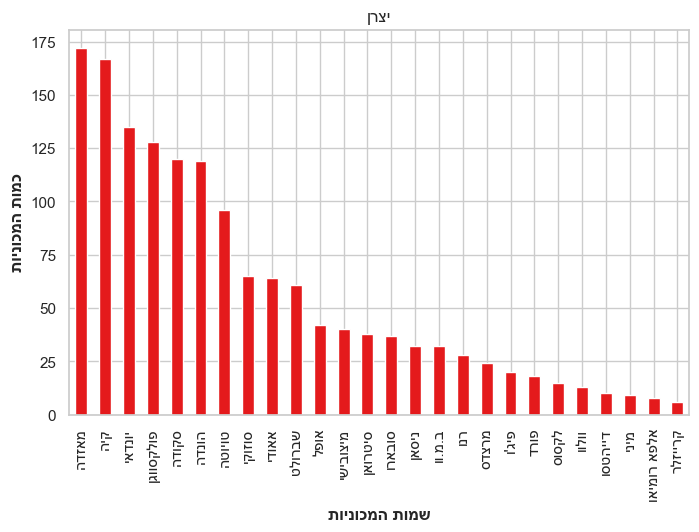

In [33]:
ax = df_p_v['Processed_manufactor_visual'].value_counts().plot(kind='bar', stacked=True, colormap='Set1')
ax.title.set_text(get_display(arabic_reshaper.reshape('יצרן')))
plt.xlabel(get_display(arabic_reshaper.reshape("שמות המכוניות")), fontweight='bold')
plt.ylabel(get_display(arabic_reshaper.reshape("כמות המכוניות")), fontweight='bold')

plt.show()

manufactor

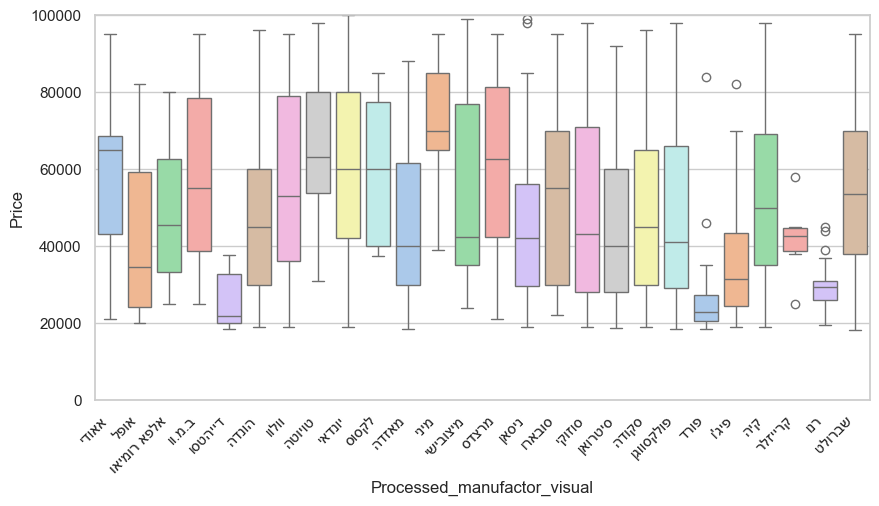

In [34]:
var = 'Processed_manufactor_visual'
data = pd.concat([df_p_v['Price'], df_p_v[var]], axis=1)
sns.set(style="whitegrid")
box_colors = sns.color_palette("pastel")

f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x=var, y="Price", data=data, palette=box_colors)
fig.set_ylim(0, 100000)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

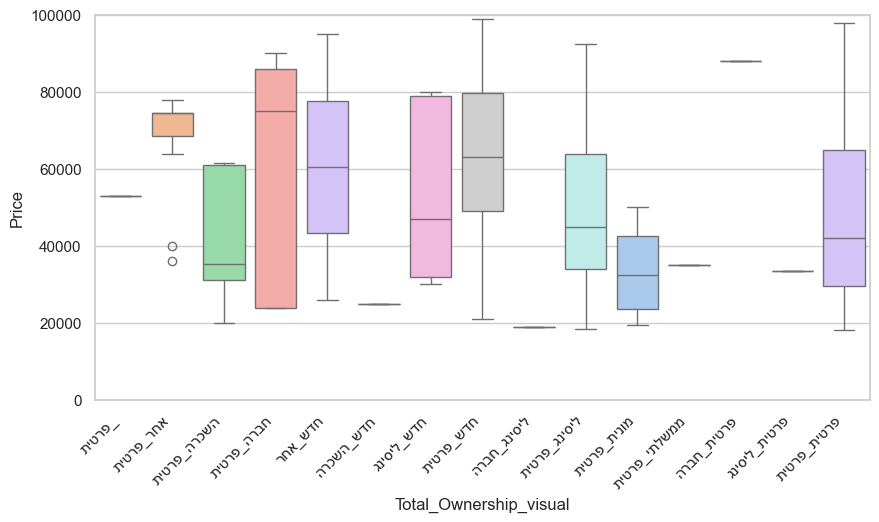

In [35]:
var = 'Total_Ownership_visual'
data = pd.concat([df_p_v['Price'], df_p_v[var]], axis=1)
sns.set(style="whitegrid")
box_colors = sns.color_palette("pastel")

f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x=var, y="Price", data=data, palette=box_colors)
fig.set_ylim(0, 100000)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

Colors

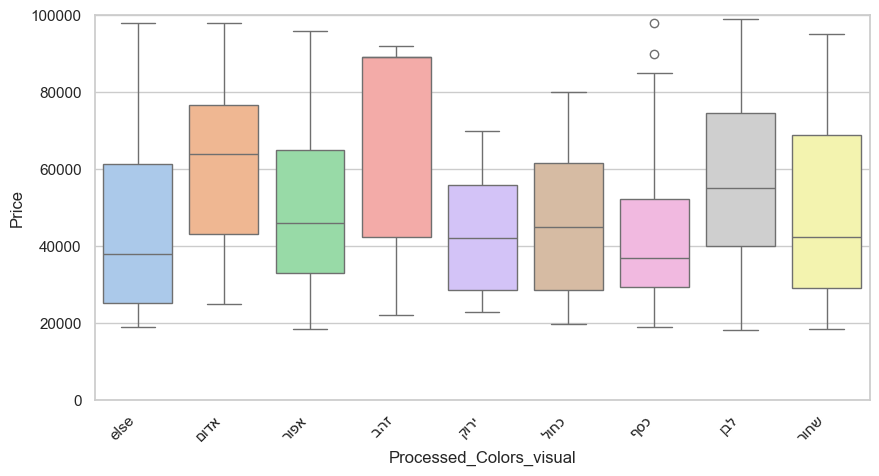

In [36]:
var = 'Processed_Colors_visual'
data = pd.concat([df_p_v['Price'], df_p_v[var]], axis=1)
sns.set(style="whitegrid")
box_colors = sns.color_palette("pastel")

f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x=var, y="Price", data=data, palette=box_colors)
fig.set_ylim(0, 100000)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

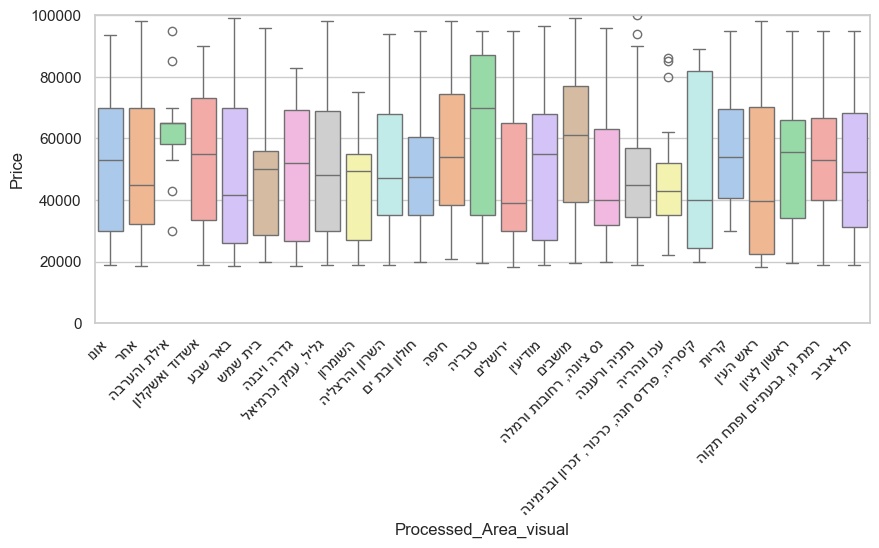

In [37]:
var = 'Processed_Area_visual'
data = pd.concat([df_p_v['Price'], df_p_v[var]], axis=1)
sns.set(style="whitegrid")
box_colors = sns.color_palette("pastel")

f, ax = plt.subplots(figsize=(10, 4))
fig = sns.boxplot(x=var, y="Price", data=data, palette=box_colors)
fig.set_ylim(0, 100000)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

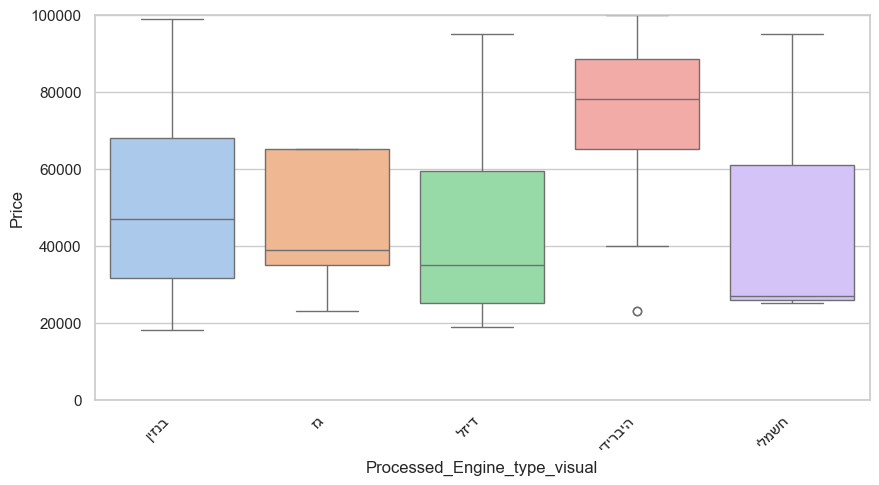

In [38]:
var = 'Processed_Engine_type_visual'
data = pd.concat([df_p_v['Price'], df_p_v[var]], axis=1)
sns.set(style="whitegrid")
box_colors = sns.color_palette("pastel")

f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x=var, y="Price", data=data, palette=box_colors)
fig.set_ylim(0, 100000)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()